In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np 
import matplotlib.pylab as plt

In [2]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [3]:
fname = "../../results_summary/all_mutations.annotated.filtered.csv"
df = pd.read_csv(fname)

In [13]:
df['IsSynonymous'].unique()

array([9, 0, 1])

In [15]:
df['genotype'] = df['file'].str.split("/").str[2].str.split("_").str[0]
df['rep'] = df['file'].str.split("/").str[2].str.split("_").str[2]
df['passage'] = df['file'].str.split("/").str[2].str.split("_").str[1].str.split("p").str[1]
df['passage'] = df['passage'].astype(int)
df['n_var'] = df['Rvar'] + df['Fvar']
df['n_tot'] = df['Rtot'] + df['Ftot']
df['frequency'] = df['n_var'] / df['n_tot']
df['position'] = df['POS'] 

df['mutation'] = (
    df['REF'] + 
    df['POS'].astype(str) + 
    df['ALT'] + 
    df['IsSynonymous'].apply(lambda x: "*" if x == 0 else "")
)

In [16]:
# rename parental
df.loc[df['sample']=="parental_p0_vs_p0", "genotype"]='0_parental'
df.loc[df['sample']=="parental_p0_vs_p0", "rep"]='_'
df.loc[df['sample']=="parental_p0_vs_p0", "passage"]='p0'

## filter for dcv

In [17]:
virus = 'dcv'

df = df[df['virus']==virus]

## check for specific mutation

In [18]:
df[df['POS']==9103]['n_tot'].min()

127.0

In [19]:
frequency_threshold = 0.01
df_temp = df[df['frequency']>=frequency_threshold]
high_freq_positions = df_temp['POS'].values

high_freq_positions, counts = np.unique(list(high_freq_positions), return_counts=True)

pos_of_interest = [x for idx_x, x in enumerate(high_freq_positions) if counts[idx_x]>1]

df_all_muts = df[(df['POS'].isin(pos_of_interest))]

mutation_order = df_all_muts.sort_values('position')['mutation'].unique()

df_heatmap = df_all_muts.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1)

positions = df_heatmap.columns.to_list()

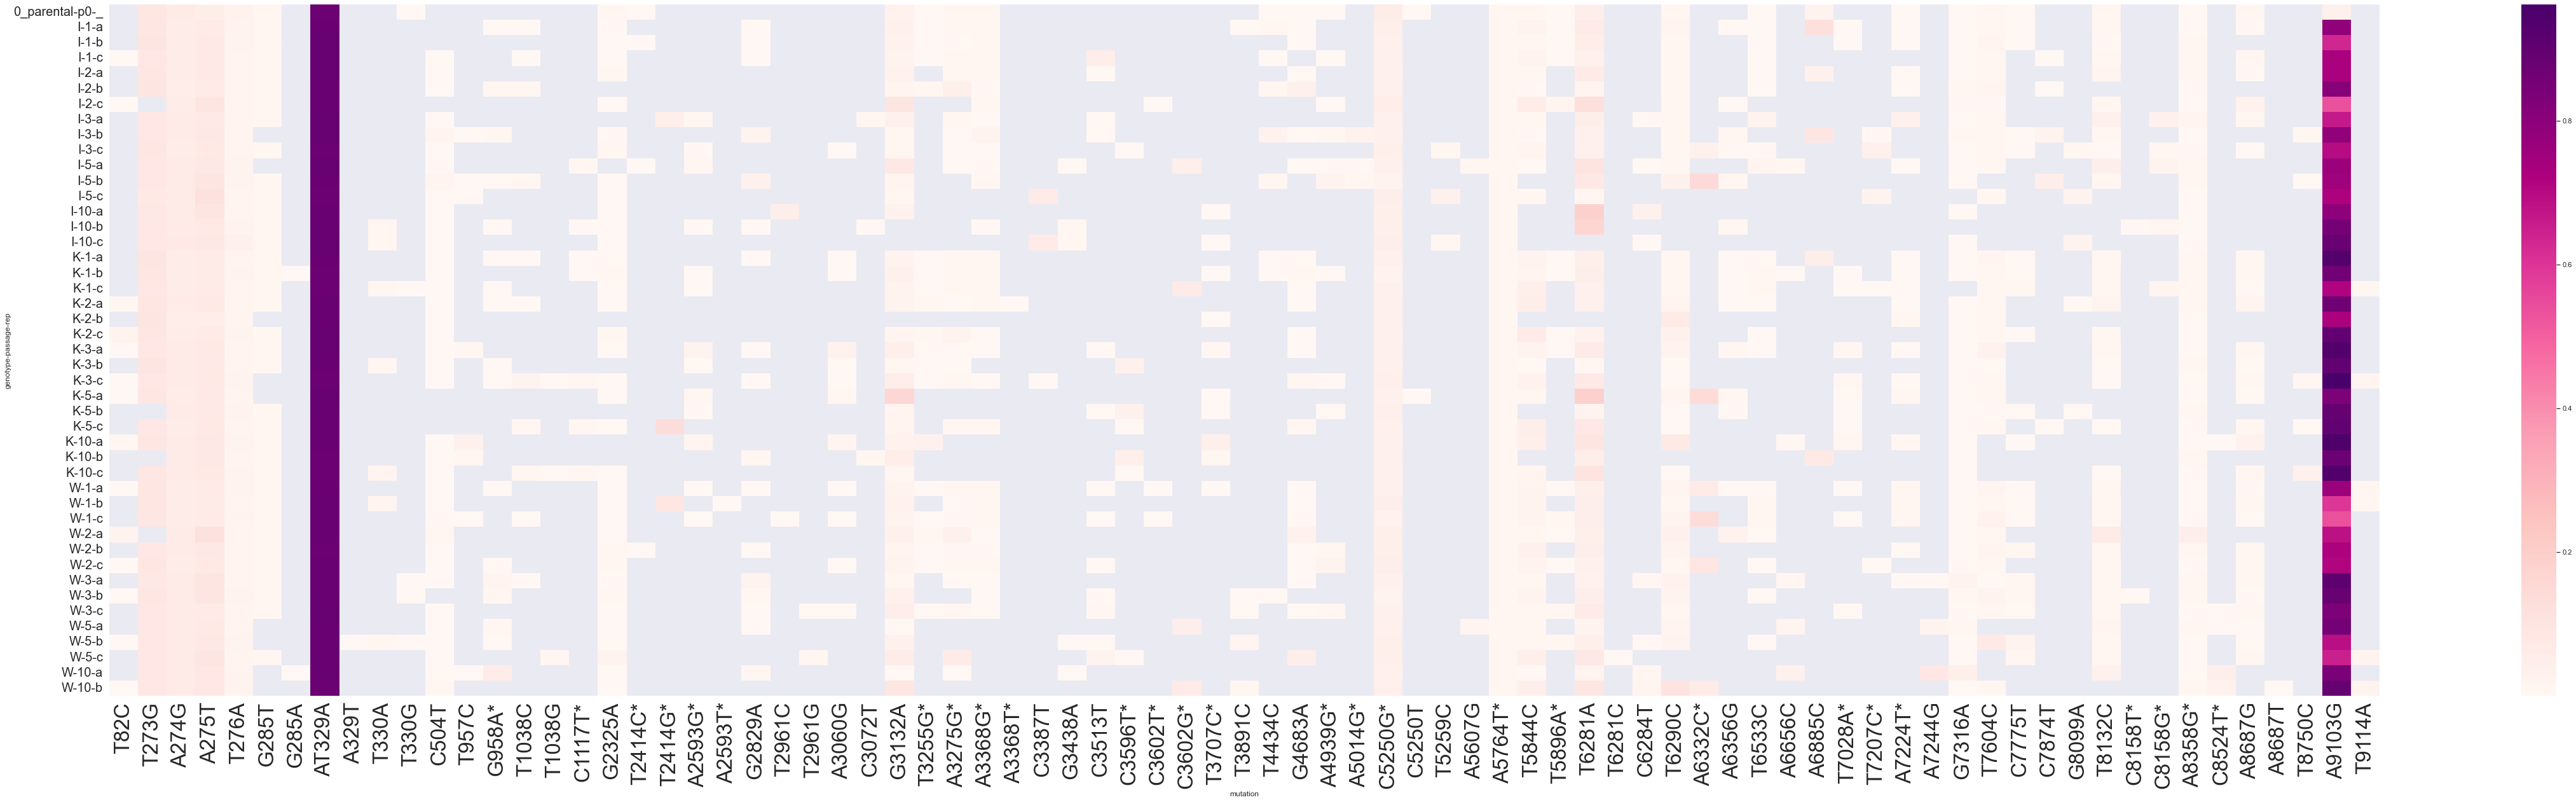

In [20]:
sns.set(rc={'figure.figsize':(80,20)})
# Pivot table 


# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu", 
                #linewidths=1, linecolor='lightgray'
               )

fig = g.get_figure()
plt.xticks(rotation=90, fontsize=33)
plt.yticks(fontsize=20)
plt.savefig(f"/Users/lfuhrmann/Downloads/dcv_heatmap_all_muts_freq.pdf")

## write mutation frequency table

In [7]:
# Filtering for the heatmap plots
# filter out mutations that show never a frequency >= 0.1 in any sample
frequency_threshold = 0.01
df_temp = df[df['frequency']>=frequency_threshold]
high_freq_positions = df_temp['POS'].values

df_temp = df[df['POS'].isin(high_freq_positions)]
df_temp['frequency'] = df_temp['frequency'].astype(float).round(6)
mutation_order = df_temp.sort_values('position')['mutation'].unique()

df_temp.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1).to_csv(f"/Users/lfuhrmann/Downloads/{virus}_heatmap_freq0.01_P0.csv")

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_36386/3204286463.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['frequency'] = df_temp['frequency'].astype(float).round(6)


## non-syn

In [31]:
#df = df[df['sample']!="parental_p0_vs_p0"]

df_NS = df[df['IsSynonymous']==0]

frequency_threshold = 0.01
df_temp = df[df['frequency']>=frequency_threshold]
high_freq_positions = df_temp['POS'].values

df_NS = df_NS[(df_NS['POS'].isin(high_freq_positions))]

In [32]:
set_mutations_no_p0 = set(df_NS['mutation'])
len(set_mutations_no_p0)

94

In [33]:
set_mutations_with_p0 = set(df_NS['mutation'])
len(set_mutations_with_p0)

94

In [34]:
mutation_order = df_NS.sort_values('position')['mutation'].unique()

df_heatmap = df_NS.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1)

positions = df_heatmap.columns.to_list()

In [35]:
df_heatmap.shape

(45, 94)

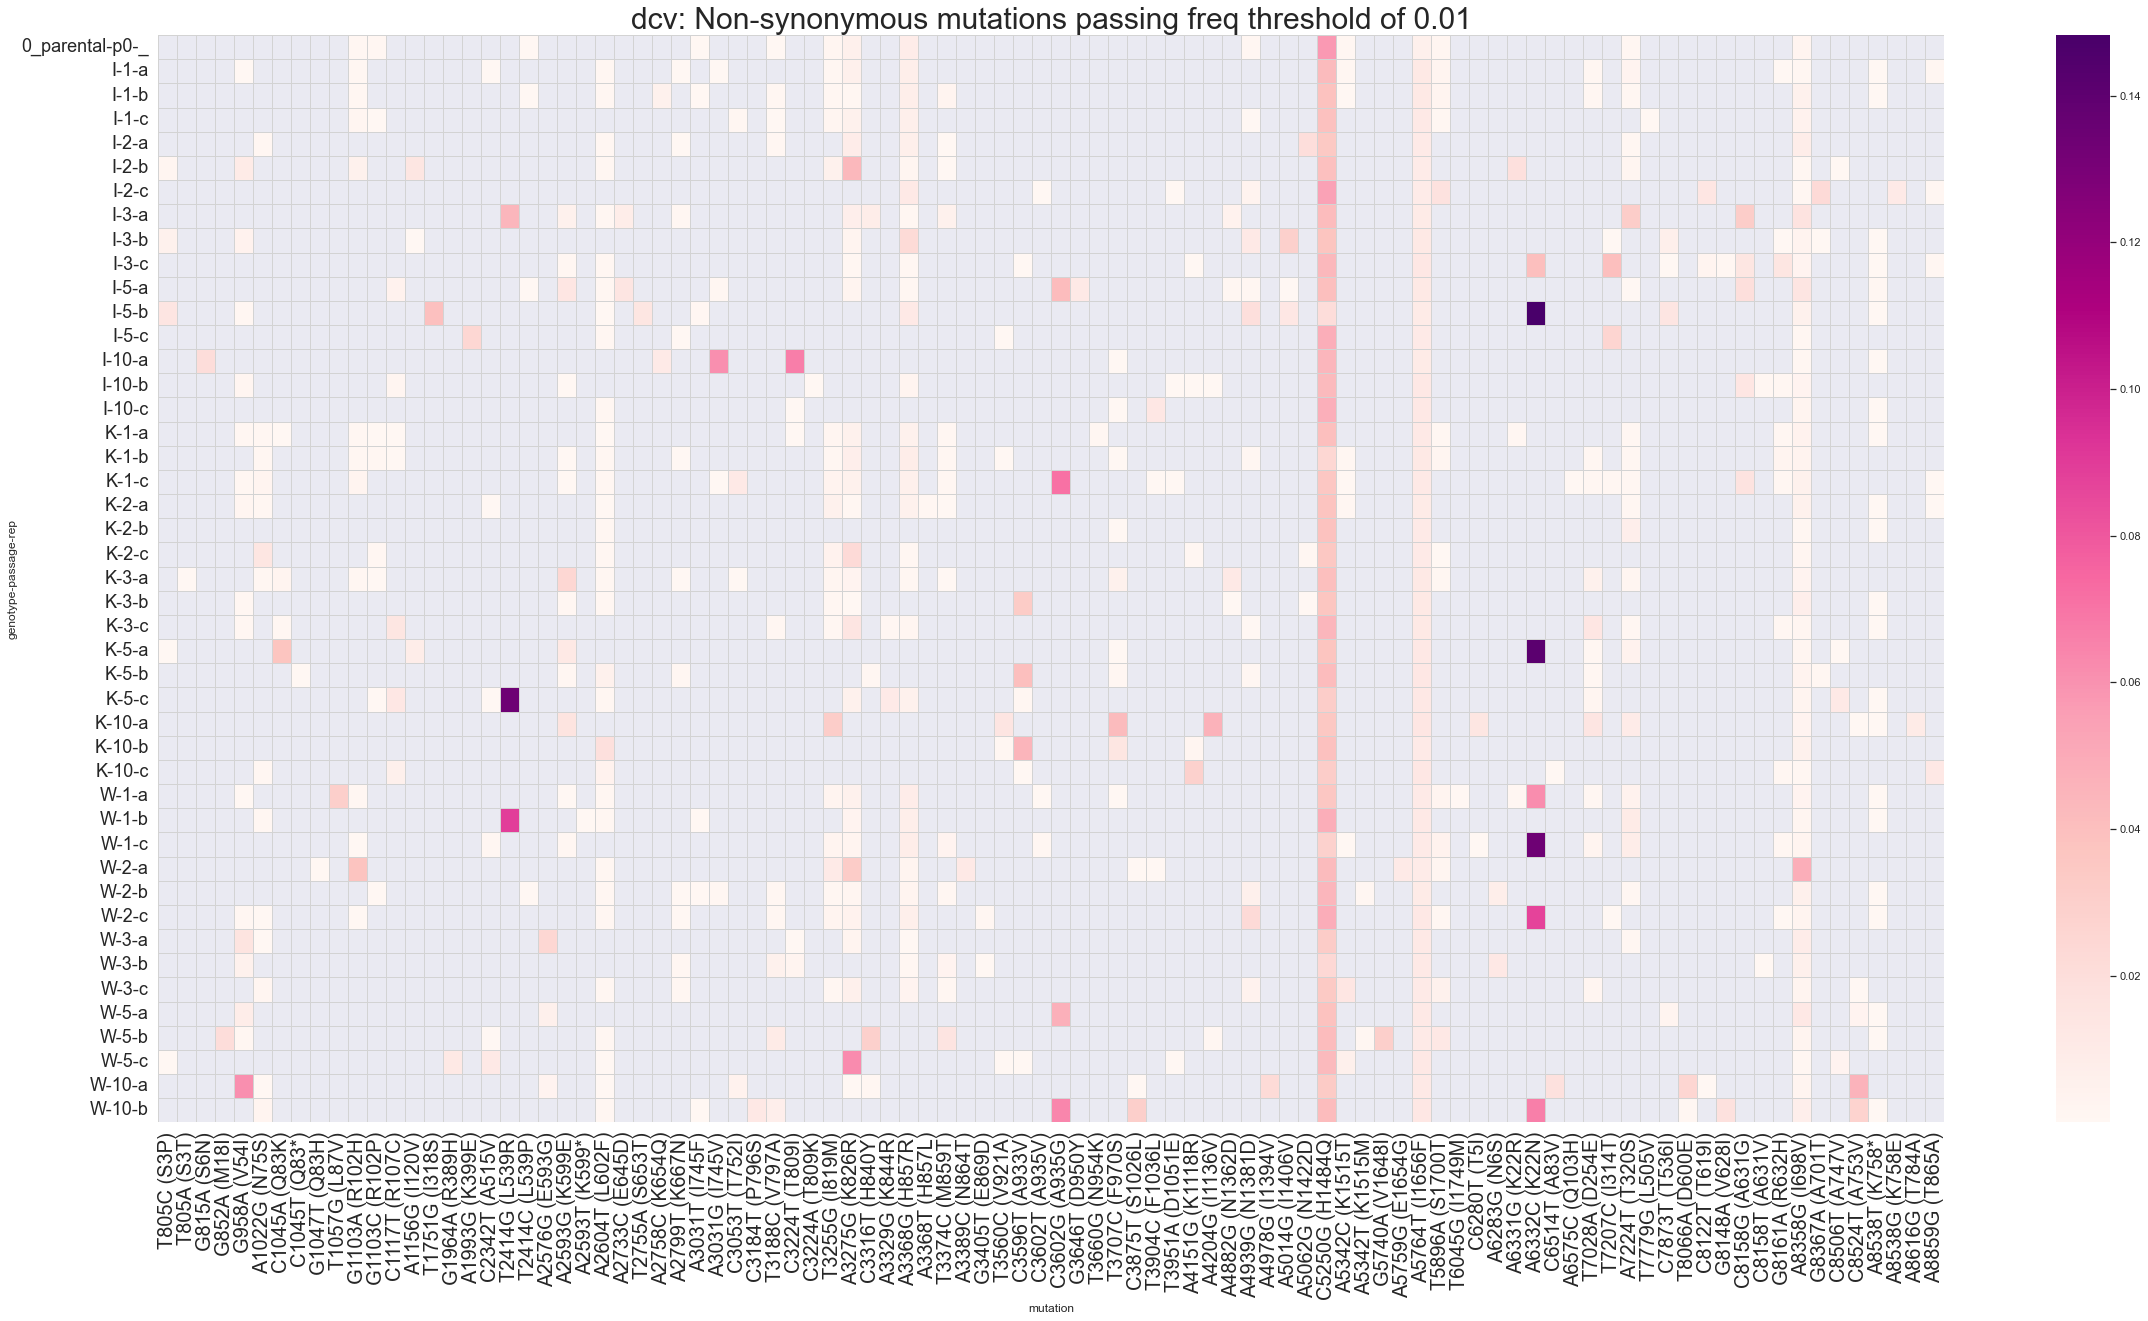

In [36]:
sns.set(rc={'figure.figsize':(40,20)})
# Pivot table 


# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu", linewidths=1, linecolor='lightgray')
fig = g.get_figure()
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=18)
plt.title(f"{virus}: Non-synonymous mutations passing freq threshold of 0.01", fontsize=30)
plt.savefig(f"/Users/lfuhrmann/Downloads/oscar_update/{virus}_heatmap_NS_freq0.01.pdf")

## non-syn minus parental mutations

In [37]:
set_muts = set(df_NS['mutation'])
len(set_muts)

94

In [38]:
set_muts_p0 = set(df_NS[df_NS['sample']=="parental_p0_vs_p0"]['mutation'])
len(set_muts_p0)

15

In [39]:
df_NS = df_NS[~(df_NS['mutation'].isin(set_muts_p0))]

In [40]:
mutation_order = df_NS.sort_values('position')['mutation'].unique()

df_heatmap = df_NS.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1)

positions = df_heatmap.columns.to_list()

In [41]:
df_heatmap.shape

(44, 79)

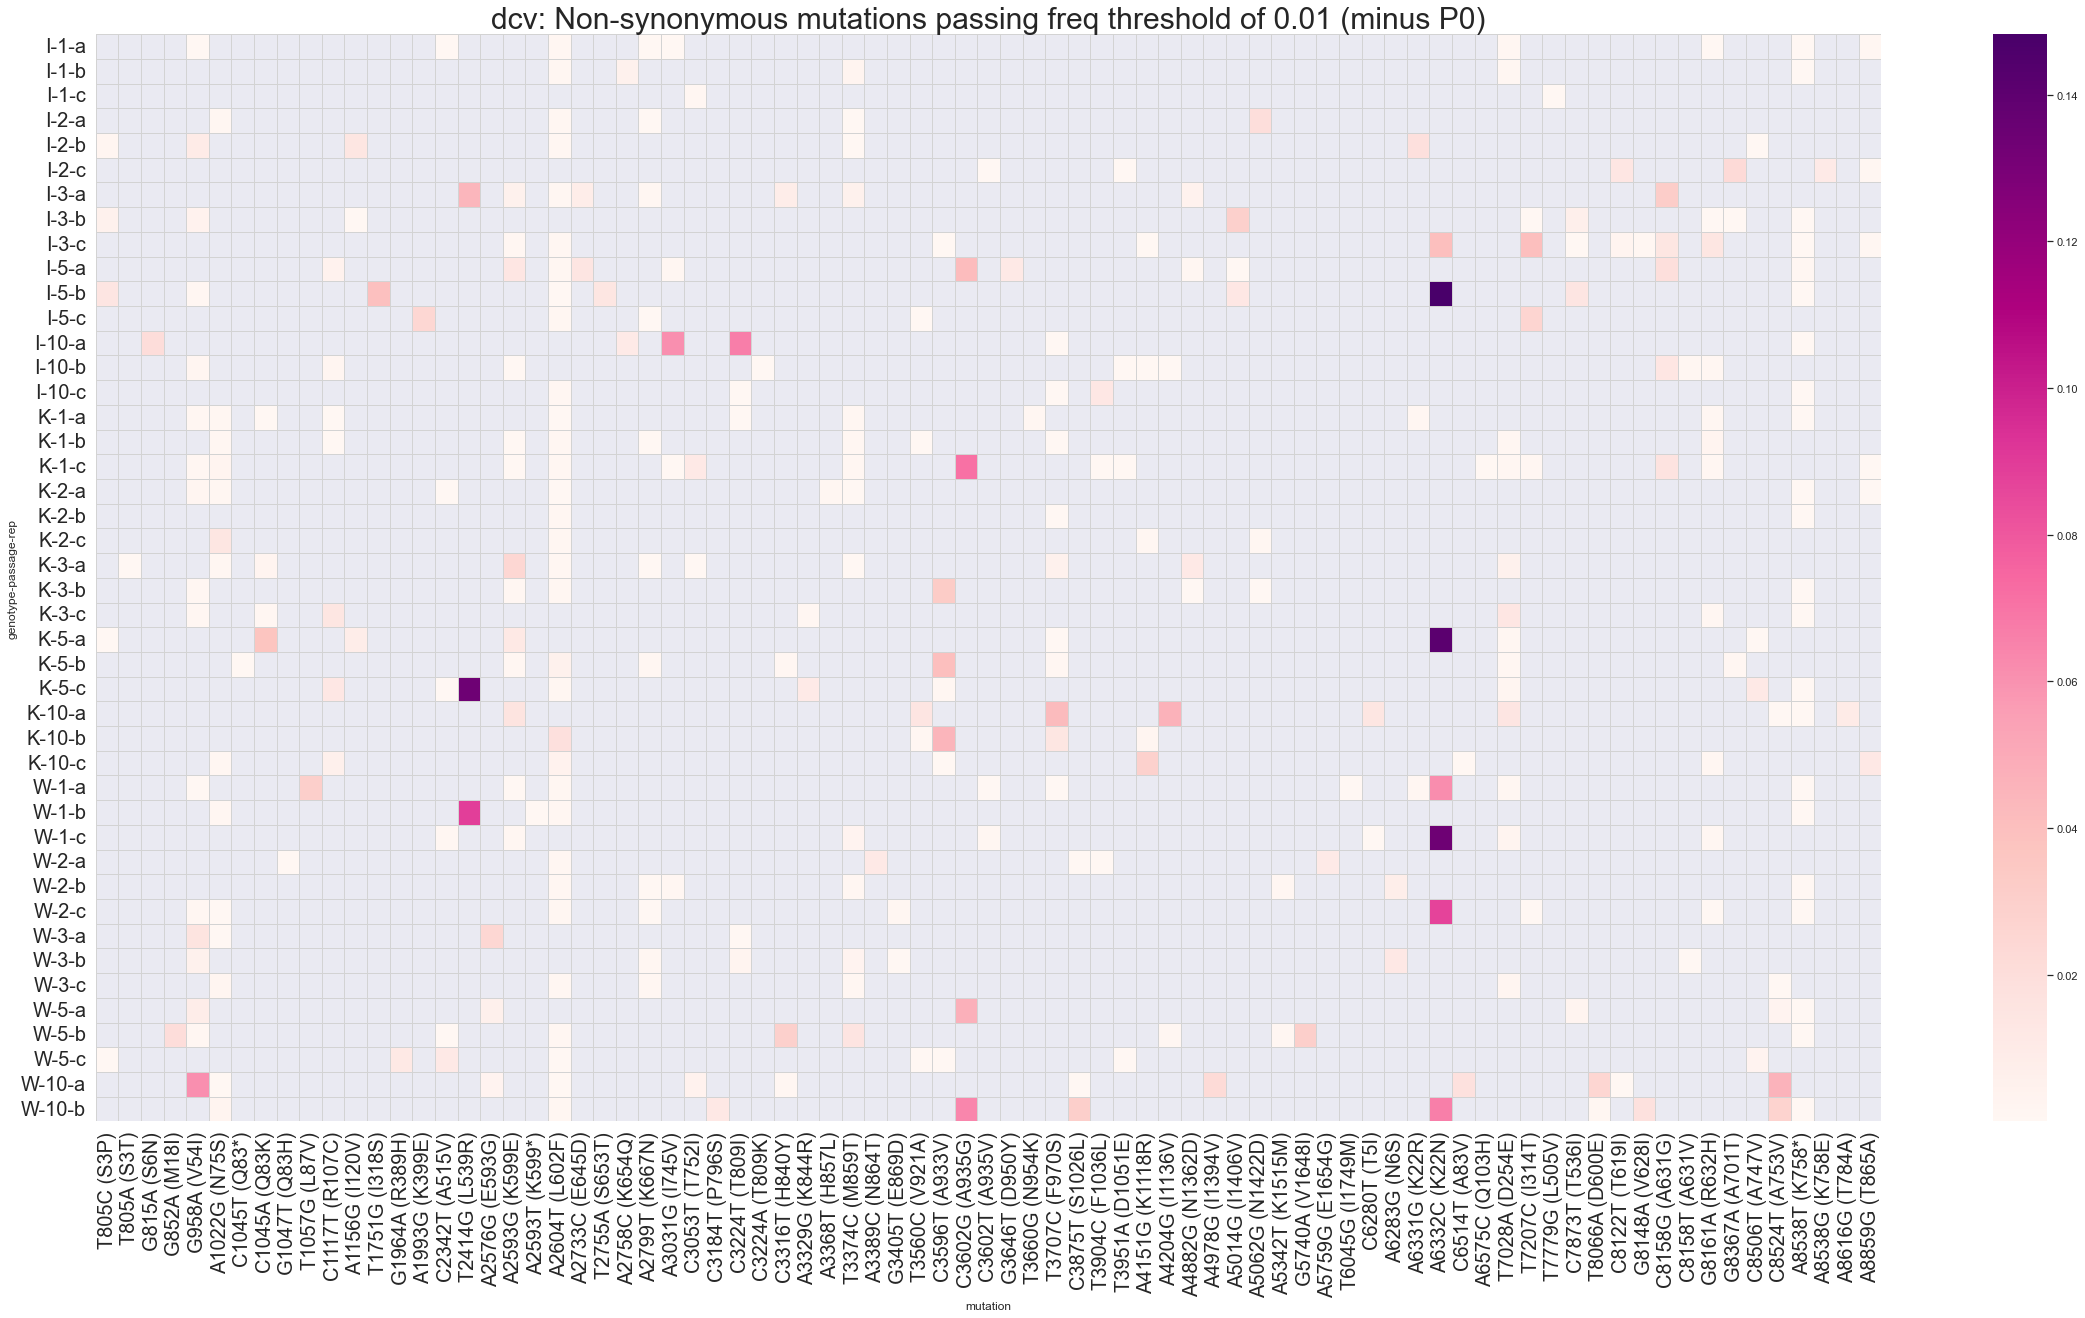

In [42]:
sns.set(rc={'figure.figsize':(40,20)})
# Pivot table 


# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu", linewidths=1, linecolor='lightgray')
fig = g.get_figure()
plt.yticks(fontsize=20)

plt.xticks(rotation=90, fontsize=20)
plt.title(f"{virus}: Non-synonymous mutations passing freq threshold of 0.01 (minus P0)", fontsize=30)
plt.savefig(f"/Users/lfuhrmann/Downloads/oscar_update/{virus}_heatmap_NS_freq0.01_minusP0.pdf")

## none non-syn

In [43]:
df['mutation'] = df['REF'] + df['POS'].astype(str) + df['ALT'] 

In [44]:
df_none_NS = df[df['IsSynonymous']!=0]

#df_none_NS = df_none_NS[df_none_NS['sample']!="parental_p0_vs_p0"]

frequency_threshold = 0.01
df_temp = df_none_NS[df_none_NS['frequency']>=frequency_threshold]
high_freq_positions = df_temp['POS'].values

df_none_NS = df_none_NS[(df_none_NS['POS'].isin(high_freq_positions))]

In [45]:
mutation_order = df_none_NS.sort_values('position')['mutation'].unique()

df_heatmap = df_none_NS.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1)

positions = df_heatmap.columns.to_list()

In [46]:
df_heatmap.shape

(45, 219)

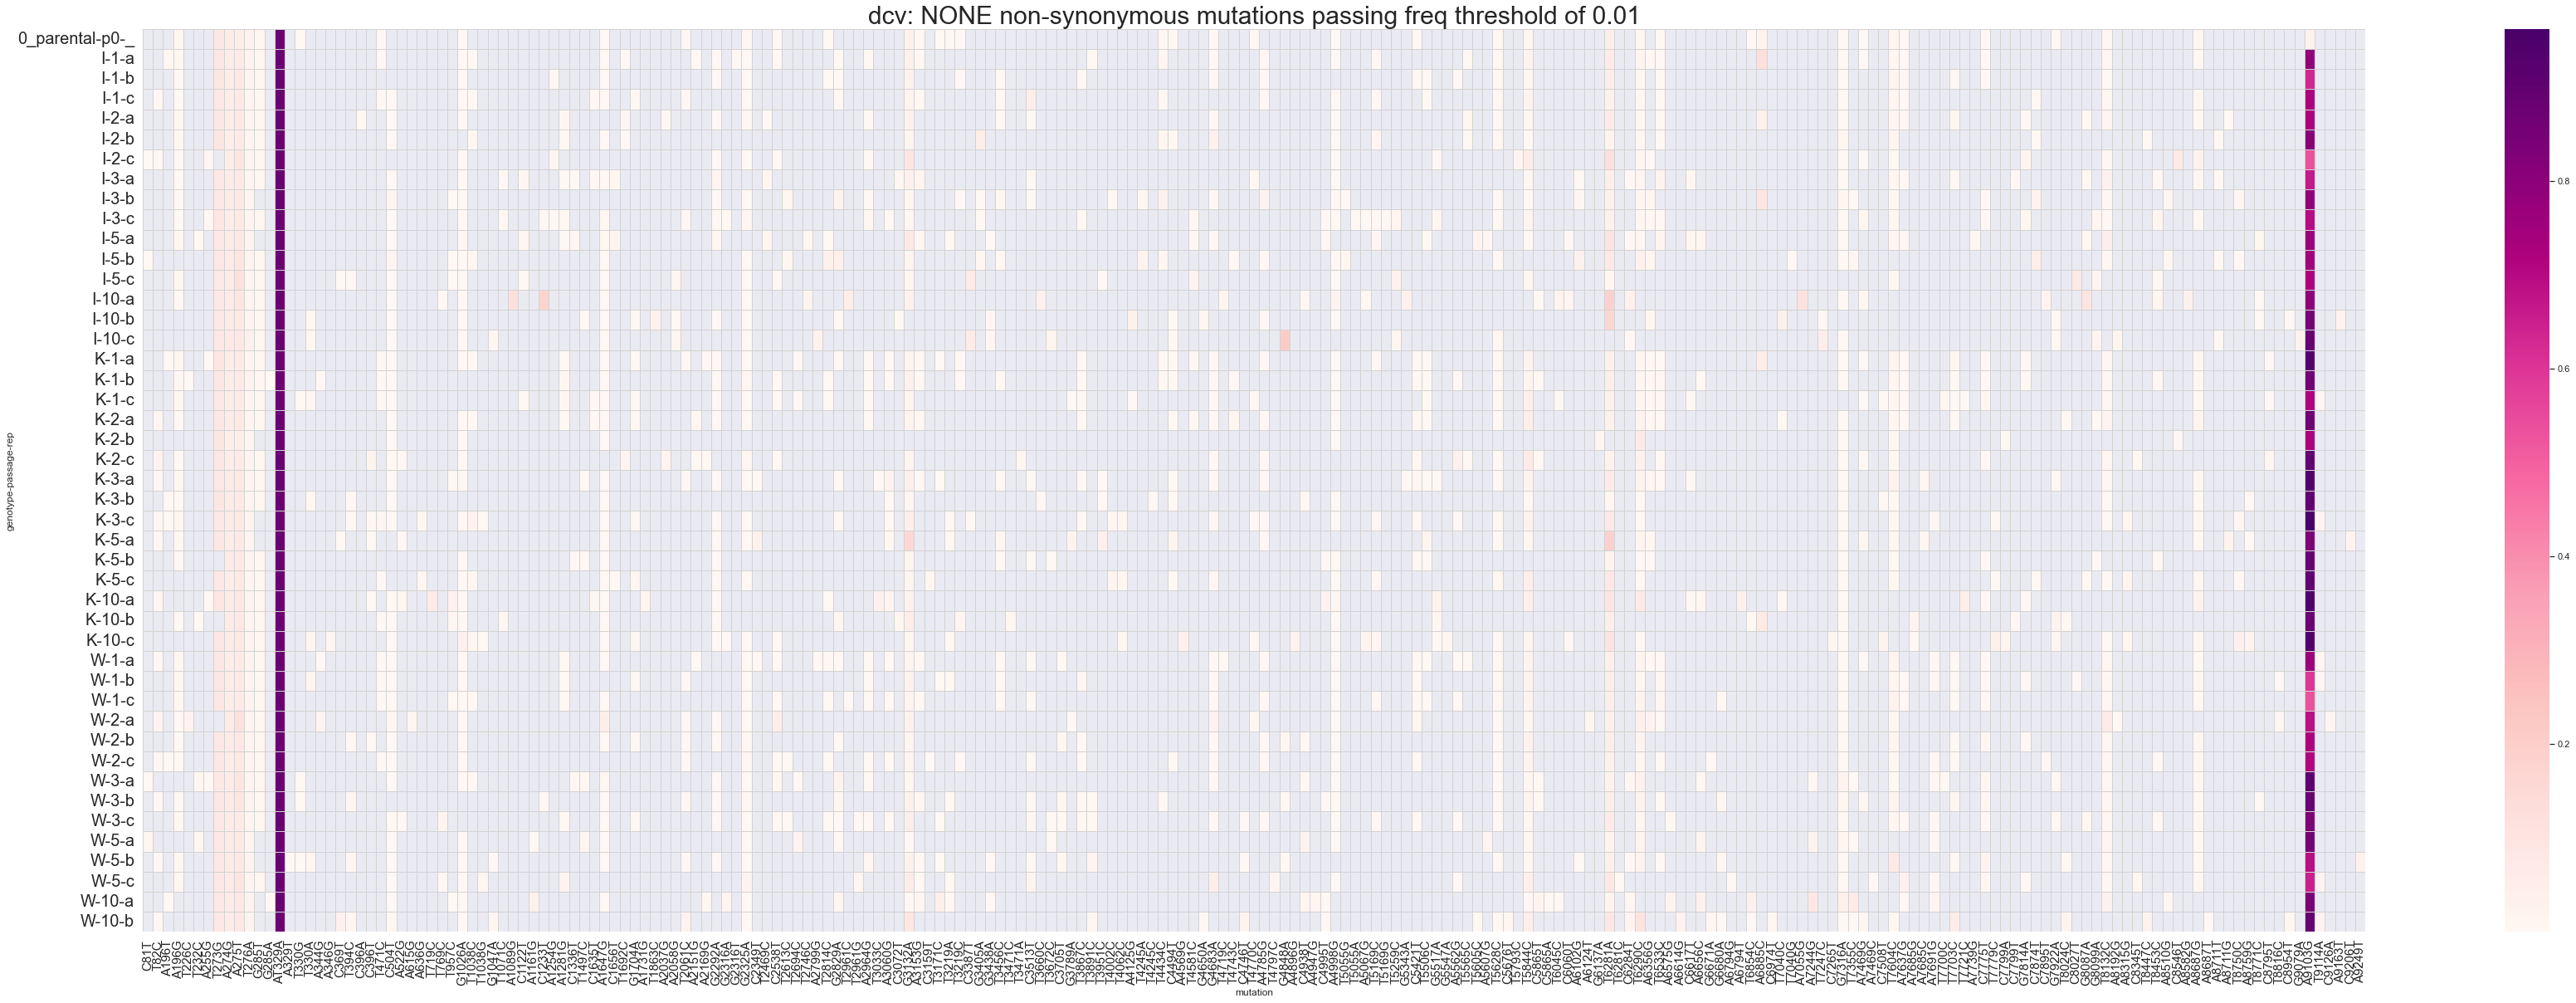

In [55]:
sns.set(rc={'figure.figsize':(60,20)})
# Pivot table 


# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu", linewidths=1, linecolor='lightgray')
fig = g.get_figure()
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)

plt.title(f"{virus}: NONE non-synonymous mutations passing freq threshold of 0.01", fontsize=30)
plt.savefig(f"/Users/lfuhrmann/Downloads/oscar_update/{virus}_heatmap_noneNS_freq0.01.pdf")

## none non-syn minus parental mutations

In [56]:
df['mutation'] = df['REF'] + df['POS'].astype(str) + df['ALT'] 

In [57]:
df_none_NS = df[df['IsSynonymous']!=0]

#df_none_NS = df_none_NS[df_none_NS['sample']!="parental_p0_vs_p0"]

frequency_threshold = 0.01
df_temp = df_none_NS[df_none_NS['frequency']>=frequency_threshold]
high_freq_positions = df_temp['POS'].values

df_none_NS = df_none_NS[(df_none_NS['POS'].isin(high_freq_positions))]

In [58]:
set_muts = set(df_none_NS['mutation'])

In [59]:
len(set_muts)

219

In [60]:
set_muts_p0 = set(df_none_NS[df_none_NS['sample']=="parental_p0_vs_p0"]['mutation'])

In [61]:
len(set_muts_p0)

42

In [62]:
df_none_NS = df_none_NS[~(df_none_NS['mutation'].isin(set_muts_p0))]

In [63]:
# security check that we substract correctly
set_muts = set(df_none_NS['mutation'])
len(set_muts)

177

In [64]:
mutation_order = df_none_NS.sort_values('position')['mutation'].unique()

df_heatmap = df_none_NS.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1)

positions = df_heatmap.columns.to_list()

In [65]:
df_heatmap.shape

(44, 177)

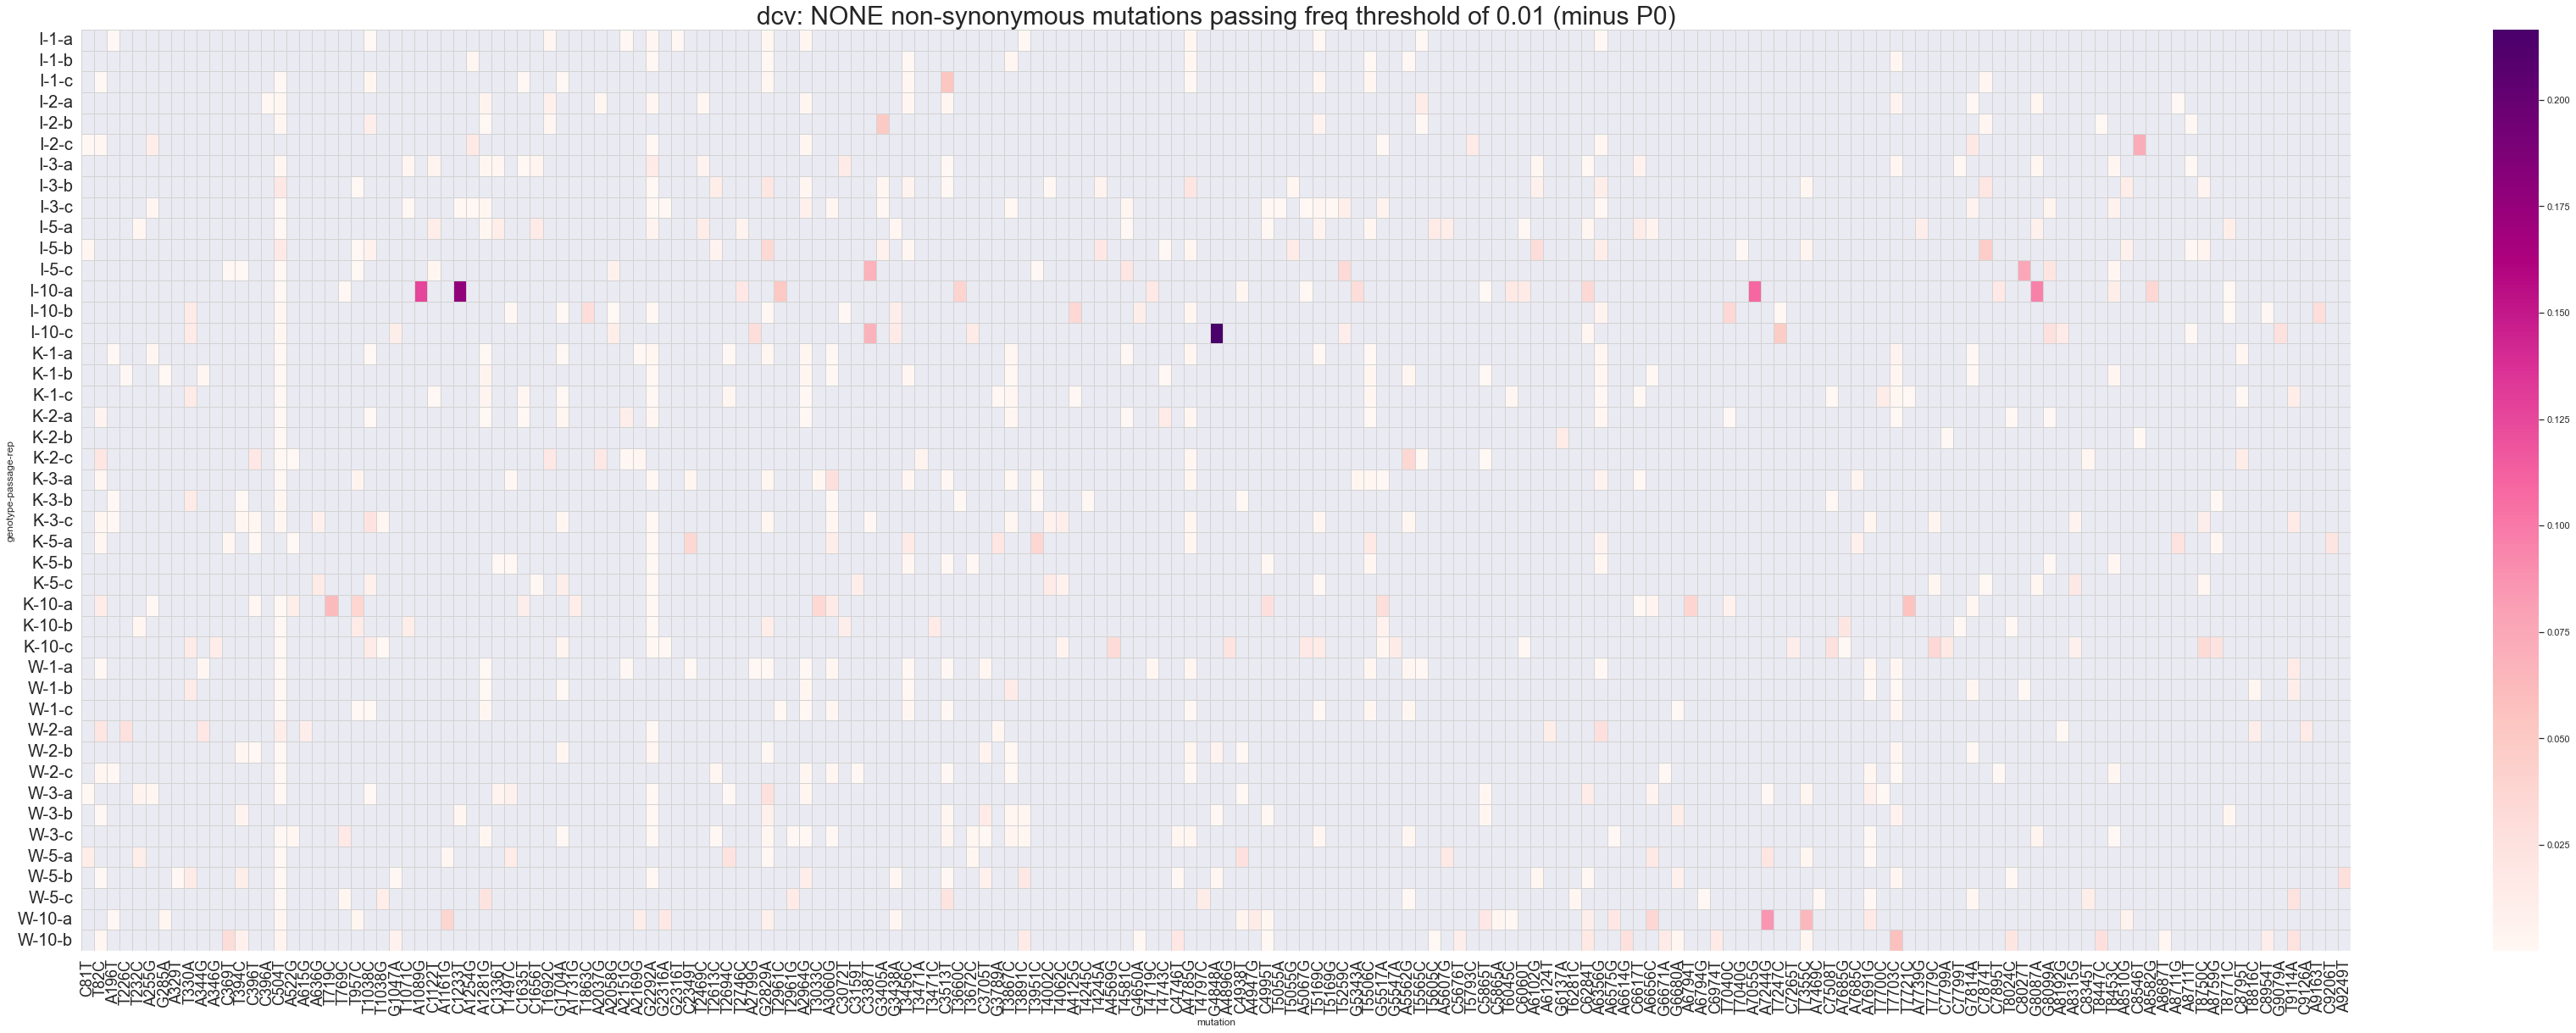

In [67]:
sns.set(rc={'figure.figsize':(60,20)})
# Pivot table 


# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu", linewidths=1, linecolor='lightgray')
fig = g.get_figure()
plt.yticks( fontsize=20)
plt.xticks(rotation=90, fontsize=18)
plt.title(f"{virus}: NONE non-synonymous mutations passing freq threshold of 0.01 (minus P0)", fontsize=30)
plt.savefig(f"/Users/lfuhrmann/Downloads/oscar_update/{virus}_heatmap_noneNS_freq0.01_minusP0.pdf")

## all mutations heatmap (to see hitchhikers) 

In [19]:
frequency_threshold = 0.1
df_temp = df[df['frequency']>=frequency_threshold]
high_freq_positions = df_temp['POS'].values

df_all_muts = df[(df['POS'].isin(high_freq_positions))]

mutation_order = df_all_muts.sort_values('position')['mutation'].unique()

df_heatmap = df_all_muts.pivot_table(values='frequency', 
                                    index=[ 'genotype', 'passage', 'rep'], 
                                    columns='mutation', 
                                    aggfunc=np.max,
                                    #fill_value=0
                                   ).reindex(mutation_order, axis=1)

positions = df_heatmap.columns.to_list()

In [20]:
df_heatmap.shape

(45, 16)

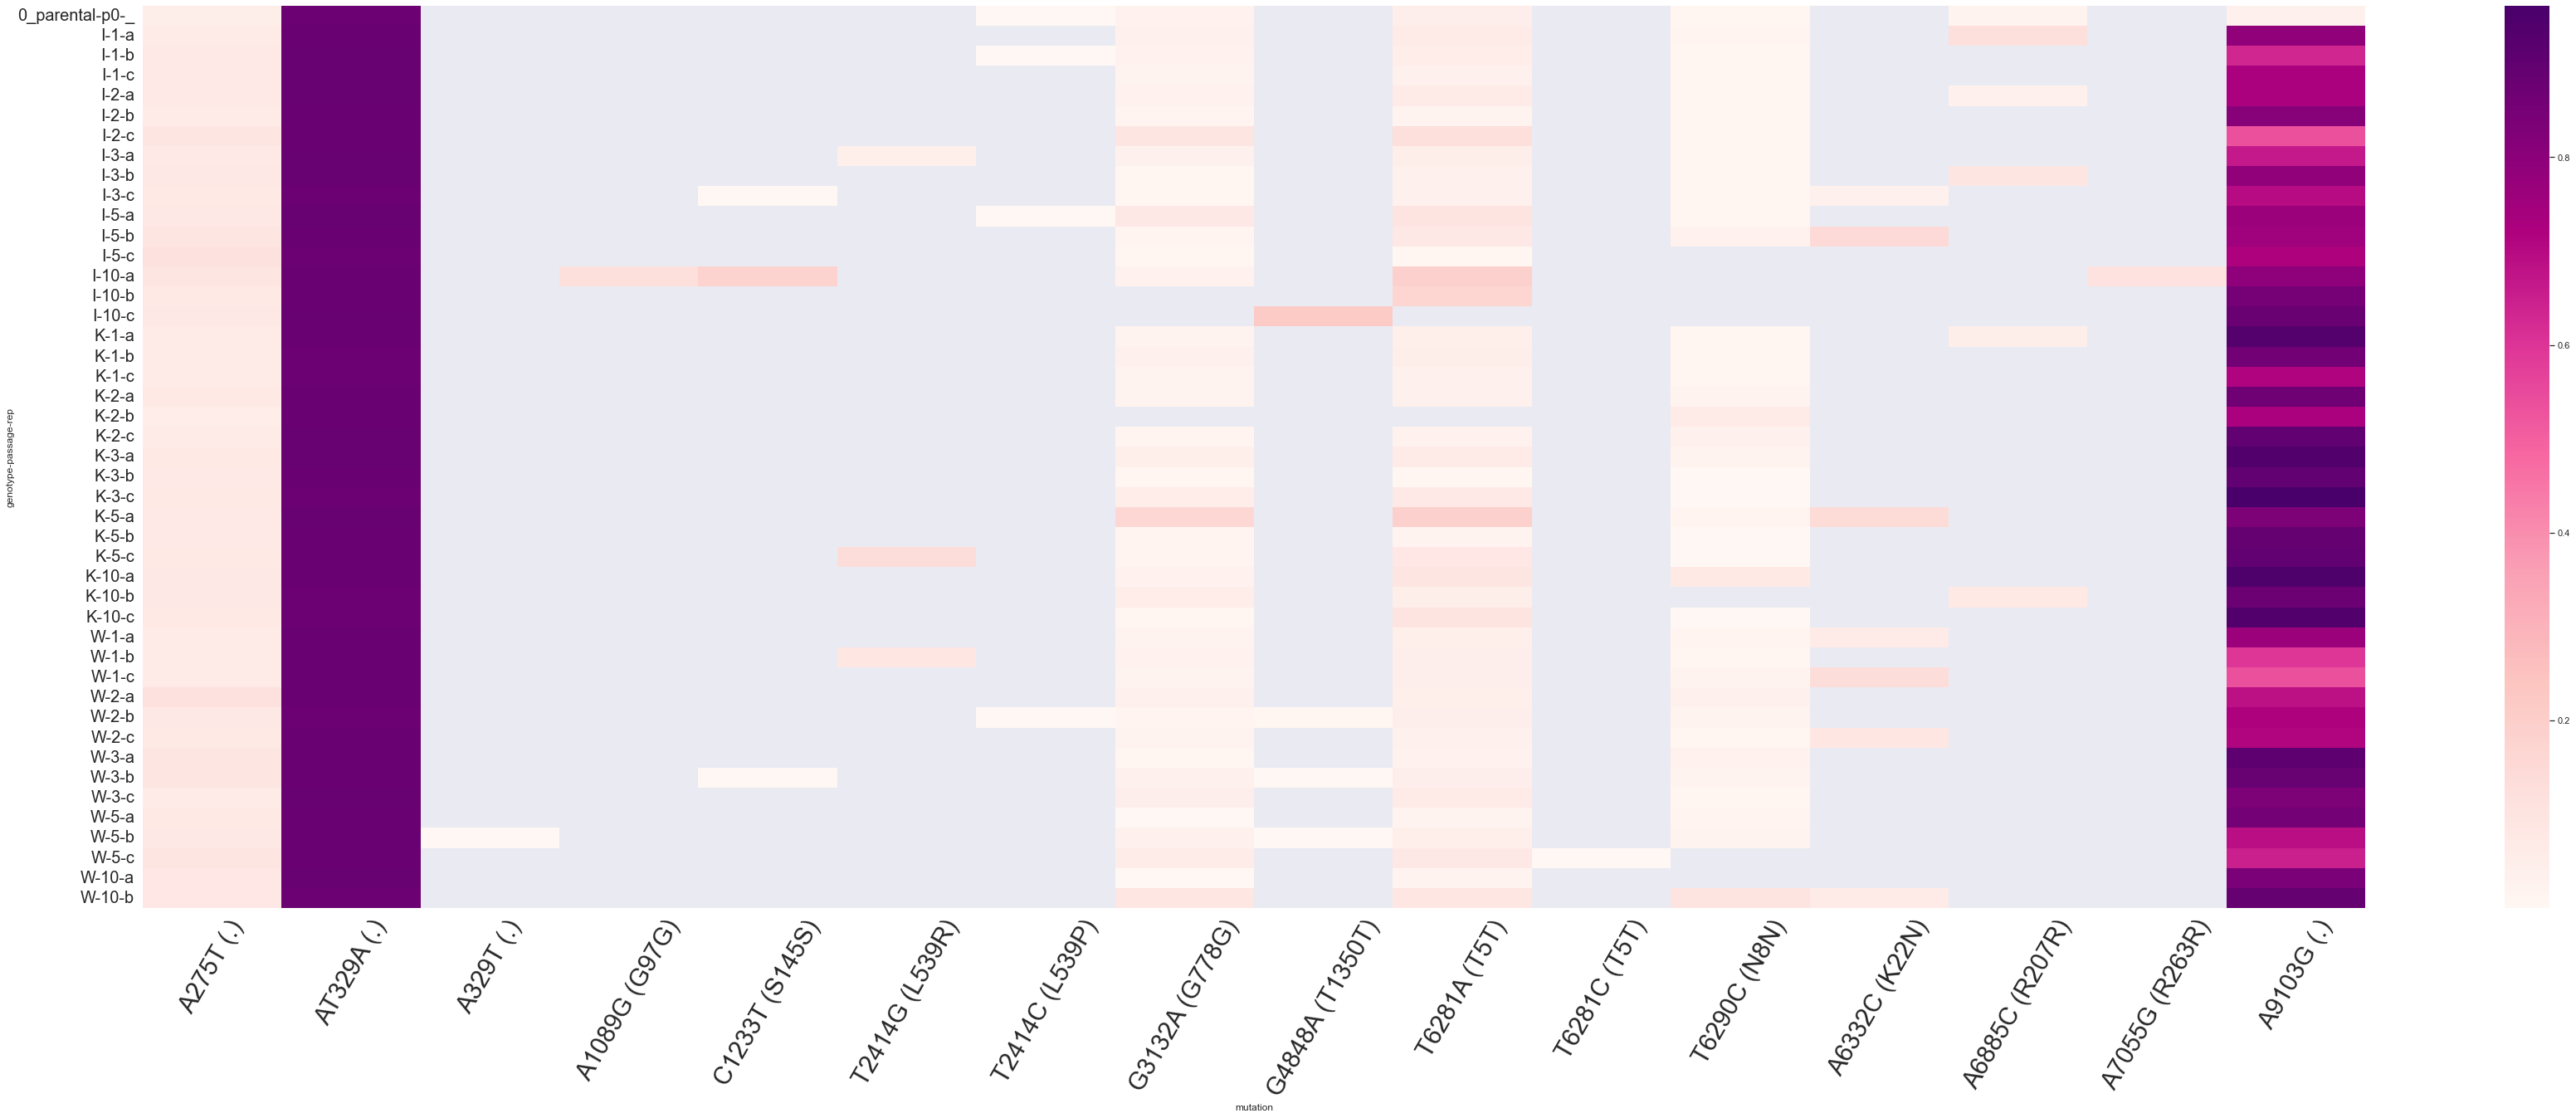

In [24]:
sns.set(rc={'figure.figsize':(60,20)})
# Pivot table 


# plot heatmap in normal scale

g = sns.heatmap(df_heatmap, xticklabels = positions, cmap="RdPu")
fig = g.get_figure()
plt.xticks(fontsize=30,rotation=60)
plt.yticks(fontsize=20)
plt.savefig(f"/Users/lfuhrmann/Downloads/dcv_heatmap_all_muts_freq0.1.pdf")